This is an example notebook to demonstrate the prediction of financial time-series data using the generalized Langevin equation (GLE) on the example of a loaded stock price trajectory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mempred import *

%matplotlib inline

ver()

This is mempred version 2.2: Fienchen
Latest feature: upgrade predictor


### Loading the data (here with yahoo finance)

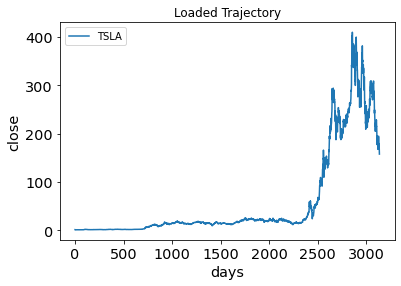

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,281494500,0,0.0
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,257806500,0,0.0
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,123282000,0,0.0
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,77097000,0,0.0
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,103003500,0,0.0


In [2]:
trj = loaddata_yahoo(symbol = 'TSLA', interval = 'daily', start_date = '1990-01-01', verbose_plot = True)
trj['Date'] = pd.to_datetime(trj['Date'])
trj.head()

### Extracting memory kernel from trajectory using the generalized Langevin equation (GLE)

plotting extracted memory kernel...


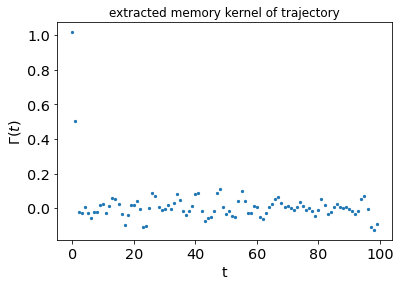

plotting running integral of kernel...


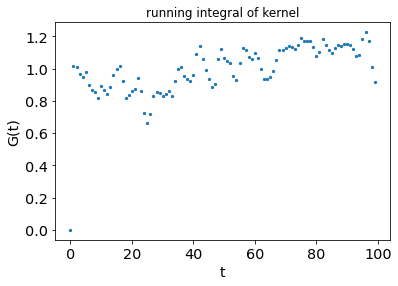

In [3]:
predict=GLEPrediction(bins=10,  cut = len(trj) ,trunc=100, dt = 1, no_fe=False, plot_pred = True)
kernel = predict.extractKernel([trj["Close"].values], trj.index, fit_kernel = False, plot_kernel = True)

### Running a GLE-prediction with arbitrary colored noise generation

plotting prediction...


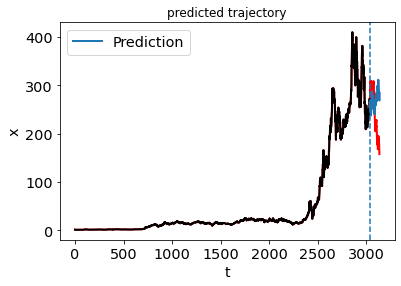

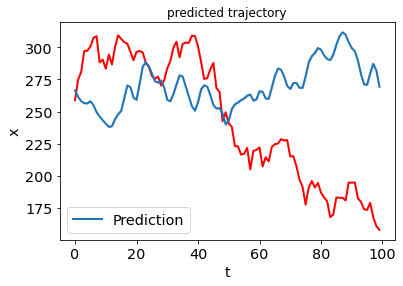

In [4]:
predict=GLEPrediction(bins=10,  cut = len(trj)-100 ,trunc=100, dt = 1, no_fe=False, plot_pred = True)
kernel = predict.extractKernel([trj["Close"].values], fit_kernel = False)
predGLE=predict.predictGLE([trj["Close"].values], n_steps=100, n_preds = 1, return_full_trjs=True, zero_noise = False)

### Running multiple predictions and calculating the average

plotting prediction...


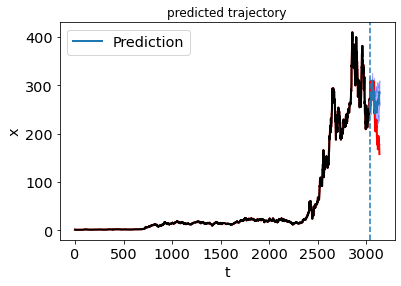

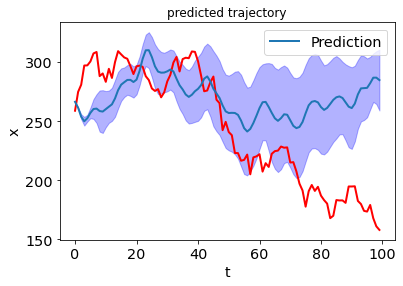

In [5]:
predGLE=predict.predictGLE([trj["Close"].values], n_steps=100, n_preds = 10, return_full_trjs=True, zero_noise = False)

### Running predictions with conditional noise generation

plotting prediction...


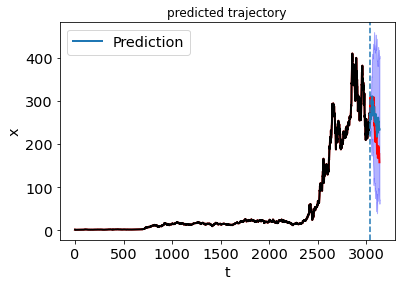

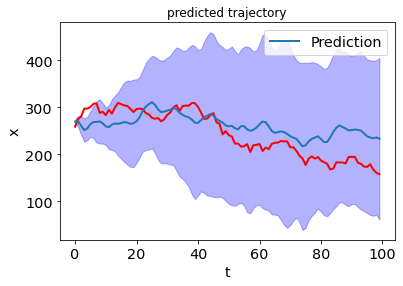

In [6]:
predGLE=predict.predictGLE([trj["Close"].values], n_steps=100, n_preds = 10, return_full_trjs=True, zero_noise = False,cond_noise = 1)

### Running a Prediction with memoryless Langevin (non-linear potential)

plotting prediction...


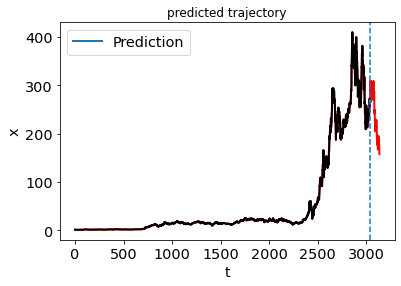

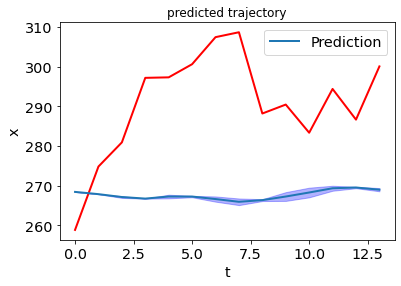

In [7]:
predict=GLEPrediction(bins=10,  cut = len(trj)-100 ,trunc=100, dt = 1, last_value_correction=True, no_fe=False, plot_pred = True)
predict.extractKernel([trj["Close"].values])
predGLE=predict.predictGLE([trj["Close"].values], n_steps=14, n_preds = 2, return_full_trjs=True, zero_noise = False, Langevin = True)

### GridSearch
find optimal values for hyper parameters in prediction (memory kernel length trunc, random force strength,...)
Attention: Only works for cut smaller than trajectory length

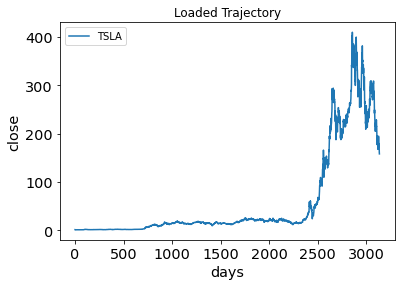

LinAlgError: Matrix is not positive definite

In [14]:
truncs = np.arange(50,200,25)
alphas = np.arange(1,400,20)
ts = [2,10]


trj = loaddata_yahoo(symbol = 'TSLA', interval = 'daily', start_date = '1990-01-01', verbose_plot = True)
cut = len(trj)-150
best_error, pred_GLE_best, best_trunc, best_alpha,best_th = mp.mp_grid_search(trj, value = 'Close', cut = cut, n_steps = 100, truncs = truncs, alphas = alphas,ts = ts)

mem = GLEPrediction(cut = cut, dt = 1, trunc = 100, plot_pred = False, no_fe = True)

kernel = mem.extractKernel([trj['Close'].values])
predGLE_default=mem.predictGLE([trj['Close'].values], n_steps = 100+1, n_preds = 10, return_full_trjs=True, zero_noise = False, alpha = 1)

plt.plot(trj['Close'][cut:cut+100].values, label = 'real')
plt.plot(predGLE_default[2], label = 'before GridSearch')
plt.plot(pred_GLE_best, label = 'after GridSearch')
plt.legend(loc = 'best')

## Extra Features:
### Plotting Performance (RMSLE) of prediction for different stocks, based on known data

predict TSLA...
> Compilation Time :  31.3166663646698
predict GOOGL...
> Compilation Time :  17.446924686431885
predict IBM...
> Compilation Time :  16.282604455947876
predict MSFT...
> Compilation Time :  43.83660864830017
predict NFLX...
> Compilation Time :  92.8021821975708


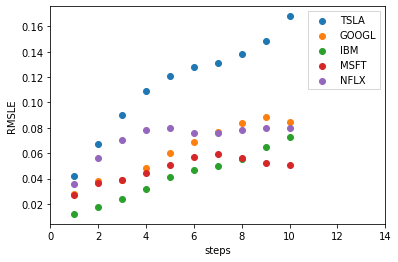

predict TSLA...
> Compilation Time :  35.9766309261322
predict GOOGL...
> Compilation Time :  21.360212564468384
predict IBM...
> Compilation Time :  20.71570324897766
predict MSFT...
> Compilation Time :  53.086788177490234
predict NFLX...
> Compilation Time :  102.18118739128113


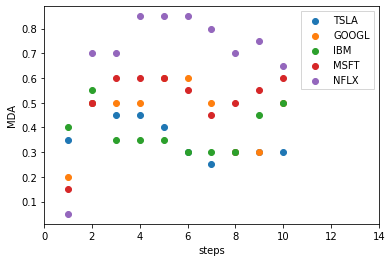

In [8]:
symbols = np.array(['TSLA', 'GOOGL', 'IBM', 'MSFT', 'NFLX'])

perform = performance_GLE(n_starts = 20, n_steps = 10)
rmsle = perform.get_scores(symbols, verbose_plot = True, metric = 'RMSLE')
mda= perform.get_scores(symbols, verbose_plot = True,metric = 'MDA')

### Calculate expected return for n_steps into future

In [9]:
changes = perform.predict_change(symbols, interval = 'daily', n_steps = 14, verbose_plot = False)

TSLA : 13.74 %
GOOGL : 2.46 %
IBM : -1.44 %
MSFT : -2.34 %
NFLX : -0.03 %


### Friction Barometer

In [10]:
data = trj['Close'].values
time = trj.index
index, gammas = friction_bar(data,time, extr_len = 200, trunc = 100, verbose_plot = False)

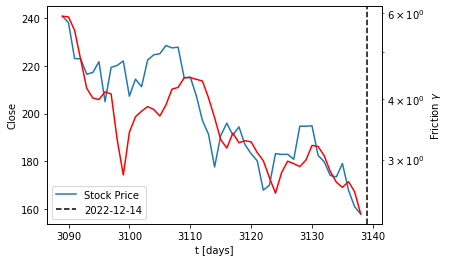

In [11]:
today = trj['Date'].dt.strftime('%Y-%m-%d')[len(trj)-1]
first = trj['Date'].dt.strftime('%Y-%m-%d')[0]

fig, ax1 = plt.subplots()

ax1.plot(trj.index[-50:], trj['Close'][-50:], label = 'Stock Price')
ax1.set_xlabel('t [days]')
ax1.set_ylabel('Close')

#ax1.axvline(x=0, linestyle = '--', color = 'k', label =first)
ax1.axvline(x=len(trj), linestyle = '--', color = 'k', label =today)
ax1.legend(loc = 'best')

ax2 = ax1.twinx()

ax2.plot(index[-50:], gammas[-50:], color = 'red')
ax2.set_yscale("log")
ax2.set_xlabel('t [days]')
ax2.set_ylabel('Friction $\\gamma$')
#ax1.axvline(x=2415, linestyle = '--', color = 'k', label =today)
#plt.xlim(870,930)
plt.show()


### Running a prediction with GBM (linear drift) (not fixed)

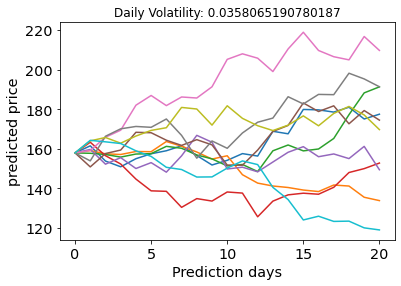

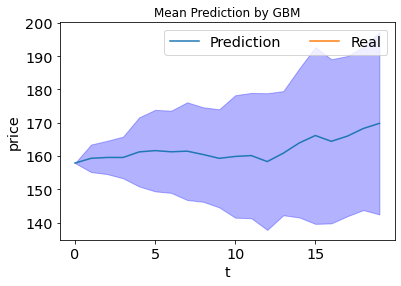

In [12]:
dt = 1
cut=len(trj)-1
n_steps=20
scen_size = 10

GBM = predictGBM(trj, value = 'Close', cut = cut, dt = 1, n_steps = n_steps, scen_size = scen_size, plot_pred = True)

